#  D&D Monster Analytics: Pipeline ETL Completa (Fixed)

**Obiettivo:** Trasformare il bestiario grezzo (`monsters_og.csv`) in un dataset pulito per il Machine Learning.

**Output:** `monsters_final_clean.csv` con Target (`cr`) come ultima colonna.

###  Fasi del Progetto
1.  **Gestione:** Caricamento e rimozione immediata di testo inutile (`desc`).
2.  **Analisi Preliminare:** Distribuzione delle classi.
3.  **Feature Extraction:** Allineamento, Taglia, Dadi Vita.
4.  **Analisi Fisica:** Relazione Taglia/HP e Statistiche.
5.  **Sensi & Linguaggi:** Conversione metrica.
6.  **Action Economy:** Analisi della pericolosità e Difese.
7.  **Imputazione:** Riempimento intelligente (Skills/Saves).
8.  **Finalizzazione:** Encoding, Ordinamento e Export.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

# --- CONFIGURAZIONE VISIVA ---
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
pd.set_option('display.max_columns', None)

print(" Ambiente configurato.")

 Ambiente configurato.


## 1. Caricamento Dati (Ingestion)
Carichiamo il file. Rimuoviamo immediatamente `desc` (descrizione testuale inutile per il modello) e le colonne di sottotipo che non useremo.

In [3]:
try:
    df = pd.read_csv("./data/monsters_og.csv")
    print(f" Dataset caricato. Shape iniziale: {df.shape}")
except FileNotFoundError:
    print("❌ ERRORE: File 'monsters_og.csv' non trovato.")

# Normalizzazione Header
df.columns = df.columns.str.lower().str.strip().str.replace("!", "", regex=False)

# --- RIMOZIONE COLONNE INUTILI ---
# Rimuoviamo 'desc' (o 'description') e colonne di sottorazza/gruppo come richiesto
cols_to_drop_now = ['desc', 'description', 'subtype', 'group', 'sub_race']
df = df.drop(columns=[c for c in cols_to_drop_now if c in df.columns], errors='ignore')

print(f" Pulizia preliminare completata (Colonna 'desc' rimossa). Shape: {df.shape}")

 Dataset caricato. Shape iniziale: (2435, 71)
 Pulizia preliminare completata (Colonna 'desc' rimossa). Shape: (2435, 68)


### 📊 Grafico 1: Distribuzione del Target (CR)
**Come leggerlo:** Questo istogramma mostra quanti mostri ci sono per ogni livello di difficoltà.
* **Sbilanciamento:** Se la barra a sinistra è altissima, significa che il dataset è pieno di mostri deboli (CR basso).
* **Coda Lunga:** Le barre a destra indicano che i mostri di alto livello sono rari.

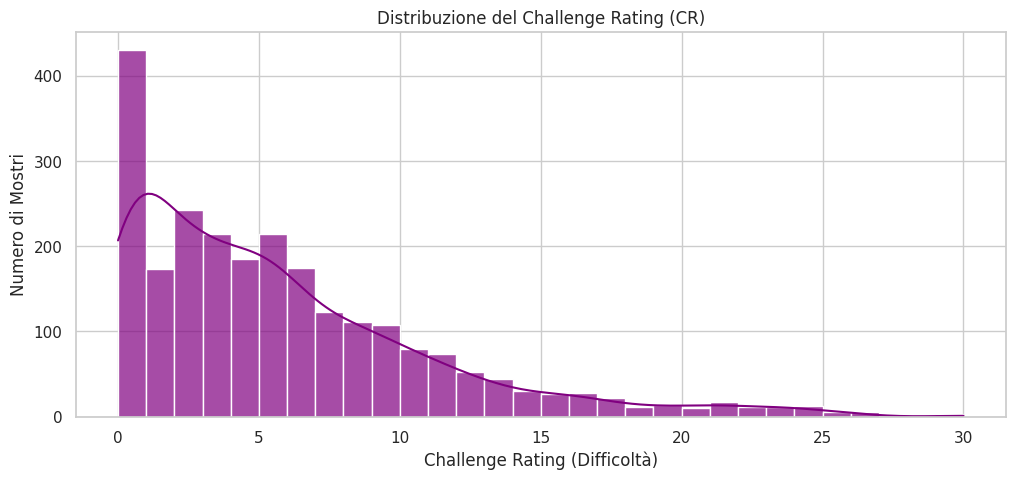

In [4]:
plt.figure(figsize=(12, 5))
if 'cr' in df.columns:
    sns.histplot(df['cr'], bins=30, kde=True, color='purple', alpha=0.7)
    plt.title('Distribuzione del Challenge Rating (CR)')
    plt.xlabel('Challenge Rating (Difficoltà)')
    plt.ylabel('Numero di Mostri')
    plt.show()

## 2. Feature Extraction: Allineamento
Mappiamo l'allineamento su coordinate etiche (Legge/Caos) e morali (Bene/Male).

In [5]:
def parse_alignment(text):
    text = str(text).lower()
    if 'unaligned' in text or text == 'nan' or 'any' in text:
        return pd.Series([0, 0])
    ethics, morale = 0, 0
    if 'lawful' in text: ethics = 1
    elif 'chaotic' in text: ethics = -1
    if 'good' in text: morale = 1
    elif 'evil' in text: morale = -1
    return pd.Series([ethics, morale])

if 'alignment' in df.columns:
    df[['ethics', 'morale']] = df['alignment'].apply(parse_alignment)
    df = df.drop(columns=['alignment'])
    print("✅ Allineamento processato.")

✅ Allineamento processato.


### 📊 Grafico 2: Bussola dell'Allineamento
**Come leggerlo:** Mostra la posizione etica dei mostri.
* **Assi:** X = Etica (Sinistra Caos, Destra Legge), Y = Morale (Giù Male, Su Bene).
* **Densità:** I punti sono sparsi ("jitter") per vedere dove si concentrano i mostri (spesso verso il "Caotico Malvagio").

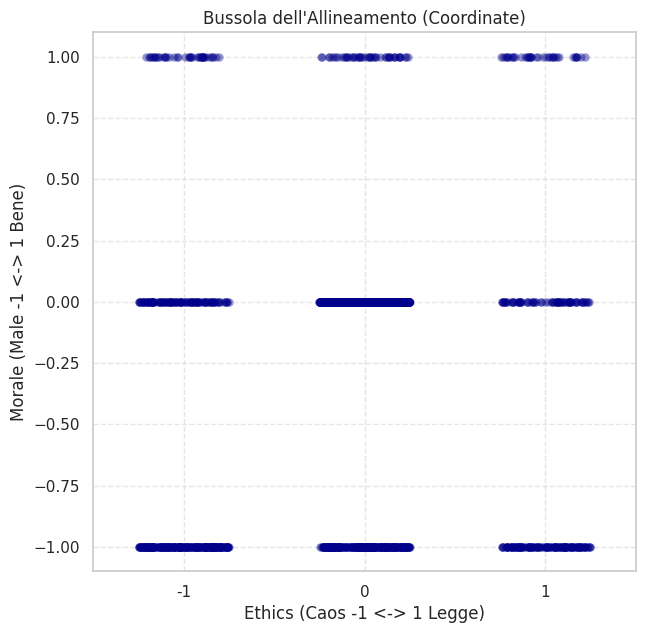

In [6]:
plt.figure(figsize=(7, 7))
if 'ethics' in df.columns:
    sns.stripplot(x='ethics', y='morale', data=df, jitter=0.25, size=6, alpha=0.4, color='darkblue')
    plt.title('Bussola dell\'Allineamento (Coordinate)')
    plt.xlabel('Ethics (Caos -1 <-> 1 Legge)')
    plt.ylabel('Morale (Male -1 <-> 1 Bene)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

## 3. Feature Extraction: Fisica (Taglia & HP)
Normalizziamo la taglia in numeri (1-7) e puliamo i Dadi Vita.

In [7]:
# Size Mapping
if 'size' in df.columns:
    size_map = {'tiny': 1, 'small': 2, 'medium': 3, 'large': 4, 'huge': 5, 'gargantuan': 6, 'titanic': 7}
    df['size_numeric'] = df['size'].astype(str).str.lower().map(size_map).fillna(3).astype(int)
    df = df.drop(columns=['size'])

# Hit Dice Extraction
def extract_hd_count(text):
    if pd.isna(text): return 0
    match = re.match(r'^(\d+)d', str(text))
    return int(match.group(1)) if match else 0

if 'hit_dice' in df.columns:
    df['hit_dice_count'] = df['hit_dice'].apply(extract_hd_count)
    df = df.drop(columns=['hit_dice'])

print(" Statistiche fisiche processate.")

 Statistiche fisiche processate.


### 📊 Grafico 3: Coerenza Fisica (Taglia vs HP)
**Come leggerlo:** Verifica la logica del gioco.
* **Trend:** I boxplot devono salire verso destra (più grande il mostro, più vita ha).
* **Scala Log:** Usiamo la scala logaritmica perché i mostri enormi hanno HP esponenzialmente più alti.

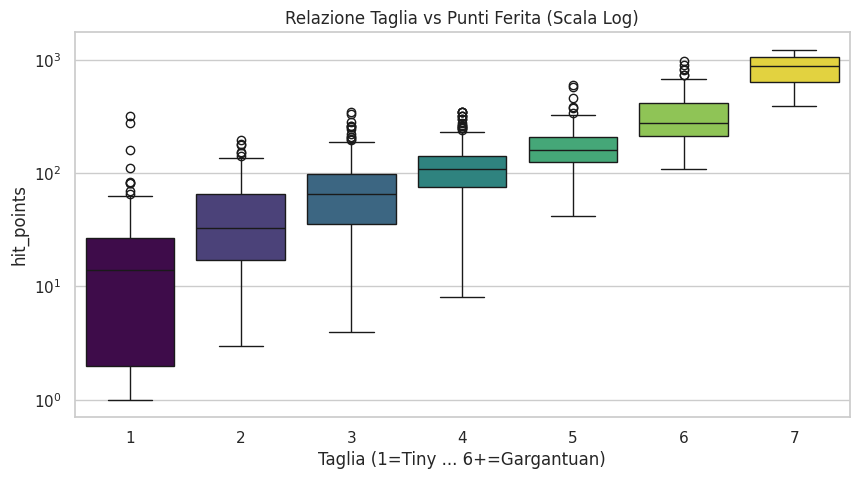

In [8]:
plt.figure(figsize=(10, 5))
if 'size_numeric' in df.columns:
    sns.boxplot(x='size_numeric', y='hit_points', data=df, hue='size_numeric', palette="viridis", legend=False)
    plt.yscale('log')
    plt.title('Relazione Taglia vs Punti Ferita (Scala Log)')
    plt.xlabel('Taglia (1=Tiny ... 6+=Gargantuan)')
    plt.show()

### 📊 Grafico 4: Distribuzione Caratteristiche (Ability Scores)
**Come leggerlo:** Mostra le statistiche medie dei mostri.
* **Confronto:** Qual è la caratteristica più alta in media? (Solitamente Forza o Costituzione).
* **Box:** La linea centrale è la mediana. I "baffi" indicano la variabilità.

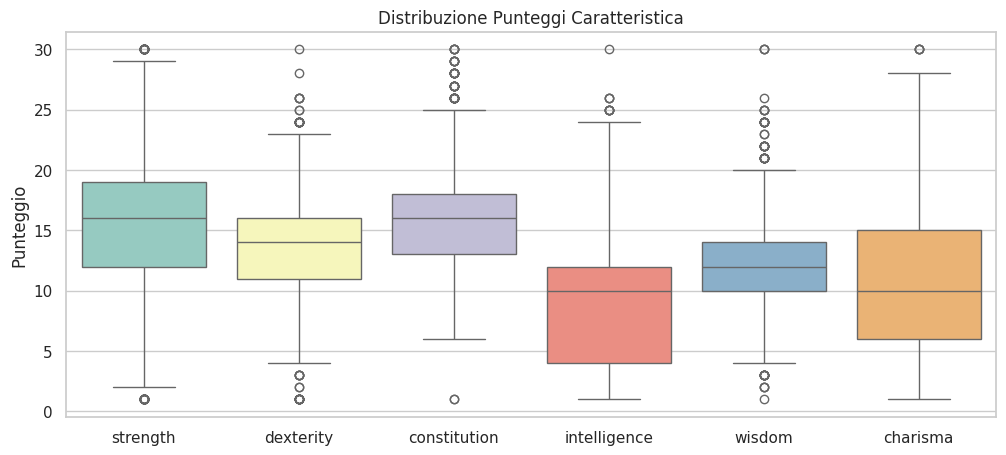

In [9]:
plt.figure(figsize=(12, 5))
stats_cols = ['strength', 'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma']
available_stats = [c for c in stats_cols if c in df.columns]
sns.boxplot(data=df[available_stats], palette="Set3")
plt.title('Distribuzione Punteggi Caratteristica')
plt.ylabel('Punteggio')
plt.show()

## 4. Sensi e Linguaggi
Normalizzazione al Sistema Internazionale (Metri).

In [10]:
def parse_sense_meters(text, sense_name):
    if pd.isna(text): return 0.0
    match = re.search(rf"{sense_name}\s+(\d+)", str(text), re.IGNORECASE)
    if match:
        return round(float(match.group(1)) * 0.3, 1) # ft -> metri
    return 0.0

if 'senses' in df.columns:
    for s in ['darkvision', 'blindsight', 'tremorsense', 'truesight']:
        df[f'sense_{s}_m'] = df['senses'].apply(lambda x: parse_sense_meters(x, s))

    df['passive_perception_extracted'] = df['senses'].str.extract(r'passive Perception\s+(\d+)', flags=re.IGNORECASE).fillna(0).astype(int)
    if 'passive_perception' not in df.columns:
        df['passive_perception'] = df['passive_perception_extracted']
    else:
        df['passive_perception'] = df['passive_perception'].fillna(df['passive_perception_extracted'])

if 'languages' in df.columns:
    df['lang_telepathy_m'] = df['languages'].apply(lambda x: parse_sense_meters(x, 'telepathy'))
    df['languages_count'] = df['languages'].fillna('').apply(lambda x: len([s for s in str(x).split(',') if s.strip()]) if x else 0)

df = df.drop(columns=['senses', 'languages', 'passive_perception_extracted'], errors='ignore')

## 5. Action Economy e Difese
Calcolo del numero di azioni e difese disponibili.

In [11]:
# --- DIFESE ---
def count_defenses(text, multiplier=1):
    if pd.isna(text) or str(text).strip() == '': return 0
    text = str(text).lower().replace(';', ',').replace(' and ', ',')
    return len([x for x in text.split(',') if x.strip()]) * multiplier

if 'damage_vulnerabilities' in df.columns:
    df['damage_vulnerabilities_score'] = df['damage_vulnerabilities'].apply(lambda x: count_defenses(x, -1))
for col in ['damage_resistances', 'damage_immunities', 'condition_immunities']:
    if col in df.columns:
        df[f'{col}_count'] = df[col].apply(count_defenses)

df = df.drop(columns=['damage_vulnerabilities', 'damage_resistances', 'damage_immunities', 'condition_immunities', 'armor_desc'], errors='ignore')

# --- AZIONI ---
def count_actions_safe(text):
    if pd.isna(text) or str(text) == '': return 0
    try:
        return len(ast.literal_eval(str(text)))
    except:
        return str(text).count("'name':")

action_cols = ['actions', 'reactions', 'legendary_actions', 'special_abilities', 'spell_list']
for col in action_cols:
    if col in df.columns:
        df[f'{col}_count'] = df[col].apply(count_actions_safe)
        df = df.drop(columns=[col])

if 'legendary_desc' in df.columns: df = df.drop(columns=['legendary_desc'])

### 📊 Grafico 5: Armor Class vs Challenge Rating
**Come leggerlo:** Mostra quanto è difficile colpire i mostri al salire del livello.
* **Linea di Tendenza:** La linea rossa mostra la media. Se un punto è molto sopra la linea, il mostro è "tanky" (molto corazzato) per il suo livello.

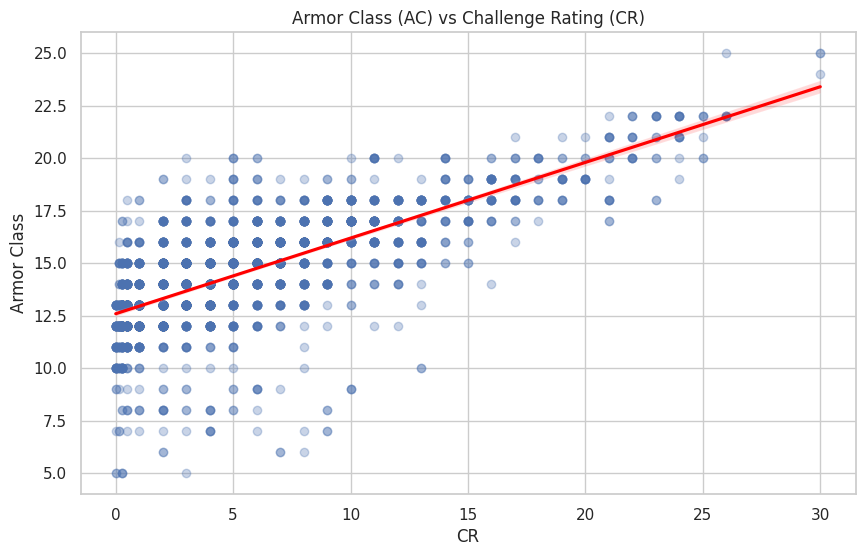

In [12]:
plt.figure(figsize=(10, 6))
if 'armor_class' in df.columns and 'cr' in df.columns:
    sns.regplot(x='cr', y='armor_class', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Armor Class (AC) vs Challenge Rating (CR)')
    plt.xlabel('CR')
    plt.ylabel('Armor Class')
    plt.show()

### 📊 Grafico 6: Action Economy
**Come leggerlo:** Conferma che i mostri boss (CR alto) fanno più cose per turno.
* **Scatter:** Ogni punto è un mostro. Ci aspettiamo che i punti salgano verso destra.

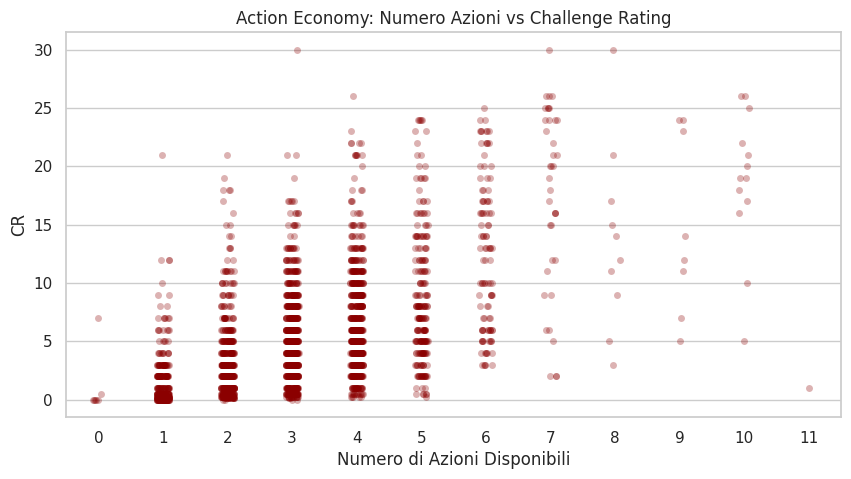

In [13]:
plt.figure(figsize=(10, 5))
if 'actions_count' in df.columns:
    sns.stripplot(x='actions_count', y='cr', data=df, alpha=0.3, color='darkred', jitter=True)
    plt.title('Action Economy: Numero Azioni vs Challenge Rating')
    plt.xlabel('Numero di Azioni Disponibili')
    plt.ylabel('CR')
    plt.show()

## 6. Imputazione Intelligente
Riempiamo i valori mancanti usando la regola del modificatore: `(Score - 10) // 2`.

In [14]:
stats_dependency = {
    'strength': ['strength_save', 'skills.athletics'],
    'dexterity': ['dexterity_save', 'skills.acrobatics', 'skills.sleight_of_hand', 'skills.stealth'],
    'constitution': ['constitution_save'],
    'intelligence': ['intelligence_save', 'skills.arcana', 'skills.history', 'skills.investigation', 'skills.nature', 'skills.religion'],
    'wisdom': ['wisdom_save', 'skills.animal_handling', 'skills.insight', 'skills.medicine', 'skills.perception', 'skills.survival'],
    'charisma': ['charisma_save', 'skills.deception', 'skills.intimidation', 'skills.performance', 'skills.persuasion']
}

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

for stat, dependents in stats_dependency.items():
    if stat in df.columns:
        modifier = (df[stat] - 10) // 2
        for dep in dependents:
            if dep in df.columns:
                df[dep] = np.where(df[dep] == 0, modifier, df[dep])

print(" Imputazione completata.")

 Imputazione completata.


## 7. Pulizia Finale e Ordinamento
Puliamo le ultime colonne sporche, applichiamo One-Hot Encoding e riordiniamo mettendo il Target `cr` alla fine.

In [15]:
# Speed Hover Binario
if 'speed.hover' in df.columns:
    df['speed.hover'] = df['speed.hover'].astype(str).str.contains("True|1", case=False).astype(int)

# Drops Finali
cols_to_drop = [
    'speed.lightwalking', 'speed.bur.', 'speed.notes', 'challenge_rating',
    'slug', 'page_no', 'img_main', 'environments',
    'document__slug', 'document__title', 'document__license_url', 'document__url',
    'sub_race' # Safety check
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# One Hot Encoding Type
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], prefix='type', dtype=int)

# --- ORDINAMENTO FINALE ---
col_groups = [
    ['name', 'size_numeric', 'ethics', 'morale'],
    ['armor_class', 'hit_points', 'hit_dice_count'],
    ['strength', 'dexterity', 'constitution', 'intelligence', 'wisdom', 'charisma'],
    ['strength_save', 'dexterity_save', 'constitution_save', 'intelligence_save', 'wisdom_save', 'charisma_save'],
    ['passive_perception', 'languages_count'],
    sorted([c for c in df.columns if 'sense_' in c or 'lang_' in c]),
    sorted([c for c in df.columns if 'skills.' in c]),
    ['damage_vulnerabilities_score', 'damage_resistances_count', 'damage_immunities_count', 'condition_immunities_count'],
    ['actions_count', 'reactions_count', 'legendary_actions_count', 'special_abilities_count', 'spell_list_count'],
    ['speed.walk', 'speed.swim', 'speed.fly', 'speed.climb', 'speed.burrow', 'speed.hover'],
    sorted([c for c in df.columns if c.startswith('type_')])
]

flat_cols = [c for group in col_groups for c in group if c in df.columns]
remaining = [c for c in df.columns if c not in flat_cols and c != 'cr']

# CR ALLA FINE
final_order = flat_cols + remaining + ['cr']
df_final = df[final_order]

output_file = "./data/monsters_final.csv"
df_final.to_csv(output_file, index=False)

print(f" FILE PRONTO: {output_file}")
print(f"📊 Shape Finale: {df_final.shape}")
print(f" Target (Ultima colonna): {df_final.columns[-1]}")

 FILE PRONTO: ./data/monsters_final.csv
📊 Shape Finale: (2435, 73)
 Target (Ultima colonna): cr


### 📊 Grafico 7: Matrice di Correlazione
**Come leggerlo:** Mostra quali caratteristiche influenzano di più il CR.
* **Rosso:** Forte correlazione positiva (es. HP alti -> CR alto).
* **Blu:** Correlazione negativa.
* **Nota:** Abbiamo escluso i nomi dei mostri per evitare errori.

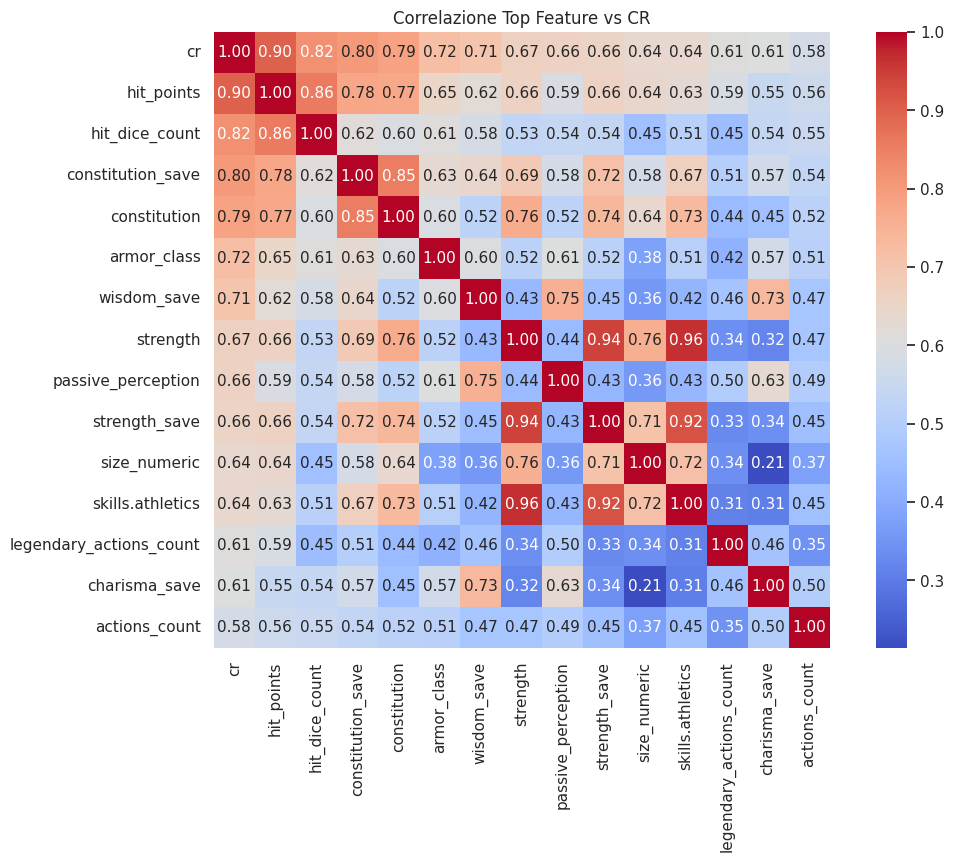

In [16]:
plt.figure(figsize=(12, 8))

# Selezioniamo SOLO le colonne numeriche
numeric_df = df_final.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Filtro Top 15 Feature
top_cols = corr_matrix['cr'].abs().sort_values(ascending=False).head(15).index
sns.heatmap(numeric_df[top_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlazione Top Feature vs CR')
plt.show()